## Table of Contents
---
1. [Imports](#import)  

   1.1 [Importing the necessary librairies for this kernel](#import_librairies)
   
   1.2 [Importing the dataset into a pandas DataFrame](#import)
 
   1.3 [Summarising Data: Statistical Descriptions](#description)
 
   1.4 [Some Observations from the STR details](#details)
 
   1.5 [Feature Manipulation](#manipulation)


2. [High Level feel for the dataset](#feel) 
   [A Through Analysis of Inpute Features ](#thorough)  
  
  * 2.1 [user_lifetime VS Inactivation](#user_lifetime)
  * 2.2 [Spending and Duration of Outoging Activitiy](#spending_duration)
  * 2.3 [GPRS](#gprs)

3.[Constructing Model](#model)
    
   3.1 [Logistic Model](#logistic)
  
  * 3.1.1 [Feature Sacling](#scaling)
  * 3.1.2 [Create Dummy Variables](#dummy) 
  * 3.1.3 [Imbalanced Data Check-Synthetic Minority Oversampling Technique](#SMOTE)
  * 3.1.4 [Recursive Feature Elimination](#RFE)
  * 3.1.5 [Performance Test](#test)
     
To be continued soon!


## 1 . Imports<a class='anchor' id=import></a>  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from pandas import DataFrame
import copy
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
import statsmodels.api as sm
import time
import os
from statsmodels.discrete.discrete_model import Logit

## 1.2 Importing the data set into a pandas Dataframe<a class='anchor' id=import></a>

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
data=pd.read_excel('/kaggle/input/mobilechurndataxlsx/mobile-churn-data.xlsx')
data=data.drop('user_account_id',axis=1)

## 1.3 Summarizing Data (Statiscal Description) <a class='anchor' id=description></a>

Before taking a rigorous examination of given input features, prepare a simple table containing descriptive statistical information.

In [ ]:
def summarizing(df):
    obs=df.shape[0] # the total number of observatinos 
    types=df.dtypes
    counts=df.apply(lambda x:x.count())
    unique=df.apply(lambda x:[x.unique()] ).transpose()
    distincts=df.apply(lambda x:x.unique().shape[0])
    null=df.isnull().sum()
    missing_rate=(round(df.isnull().sum()/obs*100,2)).astype('str')+'%'
    skew=df.skew()
    kurtosis=df.kurtosis()
    table=pd.concat([types,counts,unique,distincts,null,missing_rate,skew,kurtosis],axis=1)
    table.columns=['Data_Types','Number_of_NonNull','Unique_Values','Number_of_Unique Values','Missing_Number','Missing_Rate','Skew'
                ,'Kurtosis']
    print('The shapes of data:{0}'.format(df.shape))
    print('--'*30)
    print('Types Counts:\n',table.Data_Types.value_counts())
    print('--'*30)

In [ ]:
summarizing(data)

## 1.4 Some Obseravtions From STR details <a class='anchor' id=details></a>
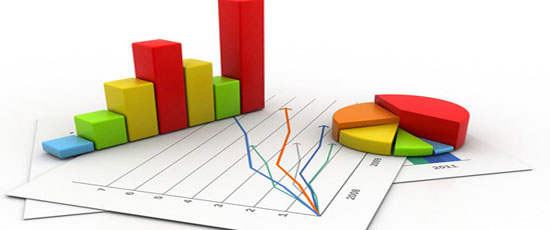

#### - Null Values: 
 We do not see a need to take care of nulls because all of the input features are free from any missing values. 
 
#### - Converion of Data type:

Some of the inputs entered into the record in the form of an integer .These features are binary variables, either 0 or 1. Therefore, to gain an analytical value, they are to be converted into a proper data type. These are following below;

                (1) user_intake
                (2) user_has_outgoing_calls
                (3) user_has_outgoing_calls
                (4) user_use_gprs
                (5) user_does_reload
                (6) churn 


#### - Skewness 

The rule of thumbs of skewnees seem to be 

If the absolute value of skewness is close to 0 but less than 1, the data set is following a normal distribution.

If the absolute value of statics shows a value greater than 1 but less than 2, it is considered moderately symmetrical.

The problem stats if the value is above either -2 and 2. They are said to be heavily asymmetrical and need to be transformed into normal if possible. 

Majority of our input varialbes are above either -2 and 2. The proper transfomrtion of data will proceeed in the later section of this kernal. 


#### -Kurtosis 

This meausrs how outelier-prone our dataset is to be. The greater value it gives, the higher chance of elminating noises from our data
we have to prevent them from disrupting our analysis. Surprisingly, some input features show anomalous values, which leads us to filter out some observations. 






In [ ]:
display(data.describe().transpose())

In [ ]:
#correlation with uuser_lifetime
display(data.corr()['user_lifetime'].sort_values(ascending=False))

## 1.5 Feature Manipulation <a class='anchor' id=manipulation></a>

In [ ]:
#merging all input features with same infomration into one variable 
data['calls_outgoing_inactive_days']=data.calls_outgoing_inactive_days
data['sms_outgoing_inactive_days']=data.sms_outgoing_inactive_days

#Remove input features conating same information
removing_features=['calls_outgoing_to_onnet_inactive_days', 'calls_outgoing_to_offnet_inactive_days','calls_outgoing_to_abroad_inactive_days',       
'sms_outgoing_to_abroad_inactive_days','sms_outgoing_inactive_days','sms_outgoing_to_onnet_inactive_days','sms_outgoing_to_offnet_inactive_days']
data=data.drop(removing_features,axis=1)
data=data.rename(columns={'user_no_outgoing_activity_in_days':'min_outgoing_inactive_days'})


In [ ]:
data.head()

## 2. High Level feel for the dataset <a class='anchor' id=feel></a>  

### 2.1 A Through Analysis of Inpute Features <a class='anchor' id=thorough></a> 
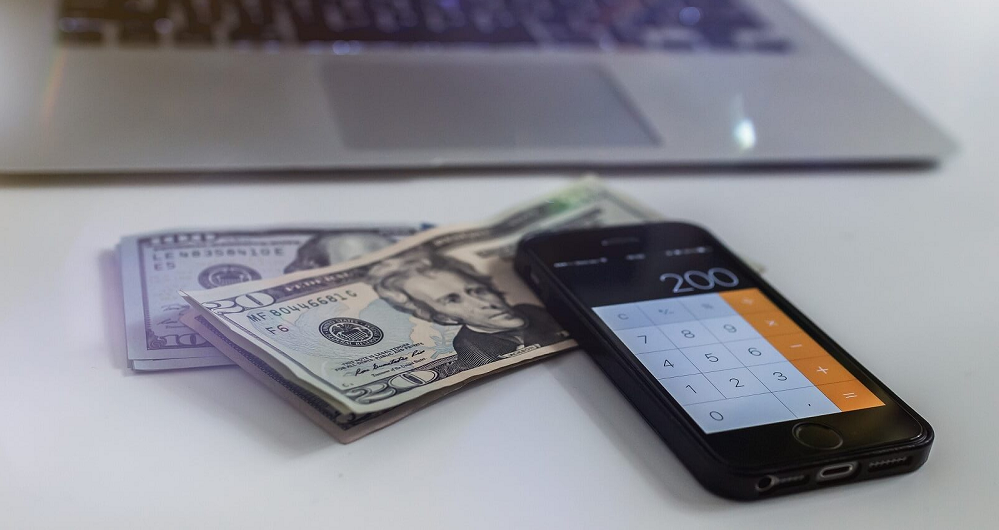

###  2.1.1 user_lifetime VS Inactivation<a class='anchor' id=user_lifetime></a>

A user lifetime has been a metric to measure the business success of companies since the longer consumers stay with them, the more revenue they are likely to earn from each consumer. Generally, we consider  the longer period as a positive sign to business. 

In [ ]:
## create another varialbe to indicate whether they have used the telecomunication service at leaste once in a month. 
data['user_has_outgoing']=(data.user_has_outgoing_calls+data.user_has_outgoing_sms).map(lambda x: 'yes' if x>0 else 'no')

In [ ]:
result1=data.pivot_table(['min_outgoing_inactive_days','user_lifetime','user_spendings'],index='user_has_outgoing',aggfunc='mean')
result1

###  (1) Life time Ratio
However, in the case of the telecom market, the measurement is of little analytical value in that a consumer inactive for a longer period may are considered as a loyal customer. Therefore, we need to bring all the relevant numbers down to another measurement to evaluate the consumer's loyalty.

$$  Lifetime\  ratio = Userlieftime \div Nubmer\  of\  days\ being\  inactive \times Monthly\ user\ Average\ spendings\div 30 $$


The highger ratio is, the more revenue companies can earn from providing services. Even though the groups who had been inactive has 4 times lon as those who had used the service at least once in the same month.  


In [ ]:
result1['life_time_ratio']=result1.user_lifetime/result1.min_outgoing_inactive_days*result1.user_spendings/30
result1

The groups who are  inactive indeed have 4 times longer life times than those who 
use the service at least once in the same month.  However, it turns out that the ratio is much higher for those active groups. 

---
###  _Lesson 1 " The interval between previous and the next outgoing activity is much shorter for user who has made either call or sent  SNS in a given moth, therby contributing to the higher spending to use the services."_
---

###  (2) Charts

In [ ]:
sns.set_style('white')
fig,ax=plt.subplots(figsize=(12,8))
ax2=ax.twinx()
sns.distplot(data[data.user_has_outgoing=='yes'].user_lifetime,color='b',ax=ax,label='active')
sns.distplot(data[data.user_has_outgoing=='no'].user_lifetime,color='coral',ax=ax2,label='inactive')
ax.set_xlabel('user_life_time',fontsize=15)
ax.set_title('Density plots of Lifetime of Two types of Users',fontsize=20)
ax.legend(loc='upper left',fontsize=14)
ax2.legend(loc='upper right',fontsize=14)


In [ ]:
fig,ax=plt.subplots(figsize=(12,8))
sns.boxplot(x='user_has_outgoing',y='user_lifetime',data=data,ax=ax)
ax.set_title('Box plots of Lifetime of Two types of Users',fontsize=20)

### (3) Removing Outlier VS Adding another categorical feature

Since we learn descriptive statistics and basic stuff about distribution, we are trained to draw charts  to see if the data is approximating a specific distribution and/or outliers exist.  Especially if you witness any points lying far from the cluster of data sets, without enough reflection on any hidden clues, we tend to get rid of them right away. We will examine the objectiveness and feasibleness of attempting to remove the distant points. 

From the charts above, We can acquire  some knowledge of consumer behavior 

Frist, those, who had been inactive for 15000 days, started to use the service again in the month of the survey. We could classify them 
a returing user.

Secondly,the users who recently joined companies and stayed connected to the company for a relatively shorter period did not make any outgoing activity in the month of the survey.  There is a greater chance for companies to deactivate prepaid connections.  Therefore, we may appoint them a potentially inactive. 

In [ ]:
result2=[['Returning Customers','Potentially Inactive','Total Counts of Both Groups','Proportion of total User After removal']]
a=data[(data.user_has_outgoing=='yes')&(data.user_lifetime>3000)].shape[0]
b=data[(data.user_has_outgoing=='no')&(data.user_lifetime<14000)].shape[0]

set1=(data.user_has_outgoing=='yes')&(data.user_lifetime<3000)
set2=(data.user_has_outgoing=='no')&(data.user_lifetime>14000)
c=data[set1^set2].shape[0]
d=str(round(c/data.shape[0]*100,2))+'%'

result2.append([a,b,c,d])
table=ff.create_table(result2)
table.layout.update(width=1100)
table.show()

If we decided to filter out both groups, the number of lost information would be in an amount to 59868 or 10% of the whole. This is absolute nonsense to treat them as outliers. 

---
###  _Lesson 2 " Create 'temporary' feature variable  whose memeber include four types; currenlty active, currentlyinactive, potentially inactive, return consumer ."_
---

In [ ]:
data['user_type']=None
data.loc[(data.user_has_outgoing=='yes')&(data.user_lifetime<3000),'user_type']='likely_active_consumers'
data.loc[(data.user_has_outgoing=='yes')&(data.user_lifetime>3000),'user_type']='return_consumers'
data.loc[(data.user_has_outgoing=='no')&(data.user_lifetime<3000),'user_type']='possilbe_inactive_consumers'
data.loc[(data.user_has_outgoing=='no')&(data.user_lifetime>3000),'user_type']='highly_inactive'

In [ ]:
fig,ax=plt.subplots(figsize=(14,5))
display(data.pivot_table('user_has_outgoing',index='user_type',columns='churn',aggfunc='count'))
data.pivot_table('user_has_outgoing',index='user_type',columns='churn',aggfunc='count').plot(kind='bar',ax=ax)
ax.set_title('Barplot for The Total Number of Four Type Users by Churn',fontsize=20)
ax.set_ylabel('number of users',fontsize=14)
ax.set_xlabel('user type',fontsize=14)

In [ ]:
#to leave only on variable 'user has_outgoing'
has_columns=[]
for i in data.columns:
    if re.search('has',i):
        has_columns.append(i)
        
#drop the rest of columns related to 'has_outgoing' columns
data=data.drop(has_columns,axis=1)

###  2.1.2 Spending and Duration of Outgoing Activity<a class='anchor' id=spending_duration></a>



In [ ]:
data.corr()['reloads_sum'].sort_values(ascending=False)[1:4]

In [ ]:
result4=data.pivot_table(['reloads_sum','user_account_balance_last','user_spendings'],index=['user_type','churn'],aggfunc='mean')
#reanme the label of churn ('no' for 0 and 'yes' for 1)
result4.index=result4.index.set_levels(['no','yes'],level=1)
result4=result4.reset_index()

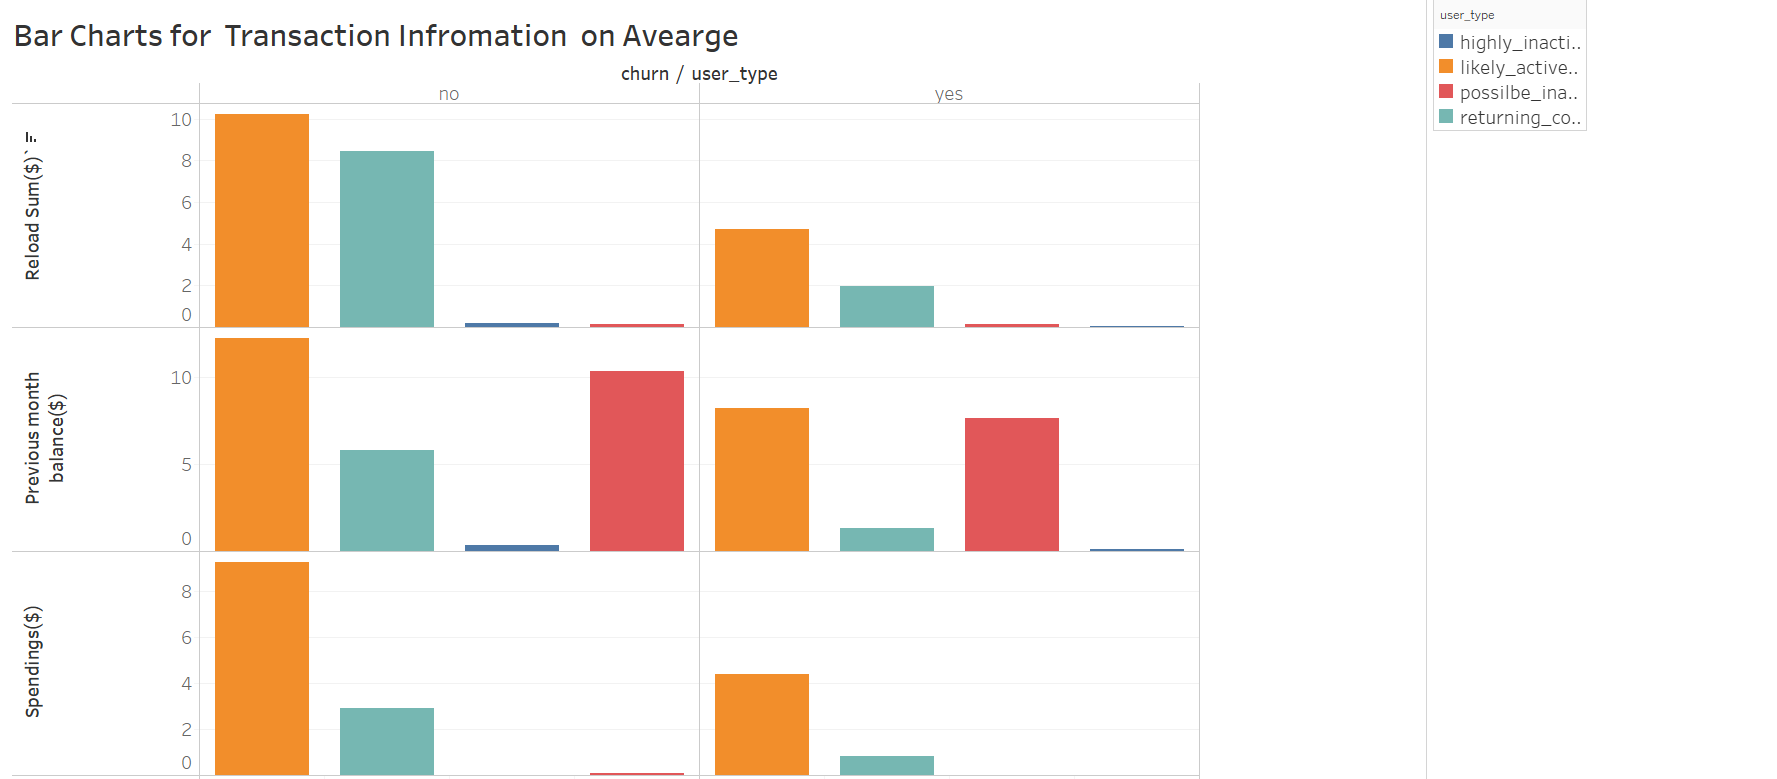

As a correlation result implies,   three input features are moving in the same direction; higher spending and greater balance from the previous month and higher reload sum on the specified month and vice versa. Our focus is on returning customers in a given month

If the customers stayed away for a long time leaving higher account balance ,they are more likely to come back to resuse the service again. Also, thier decision to come back and continue using service is undoubtedly valuable to the telephone company in that thier reload sum and spending are the second greatest, helping to boost a profit for it.

---
###  _Lesson 3 "Come out with mega promotions to attract and retain the returning consumer. "_

In [ ]:
result4=data.pivot_table(['reloads_sum','user_account_balance_last','user_spendings'],index=['user_type','churn'],aggfunc='mean')

In [ ]:
from re import search
duration=[]
for i in data.columns:
    if search('duration',i):
        duration.append(i)
duration


In [ ]:
result5=data.pivot_table(duration,index=['user_type','churn'],aggfunc='mean')
result5.index=result5.index.set_levels(['No','Yes'],level=1)
result5

###  2.1.3 GPRS <a class='anchor' id=gprs></a>

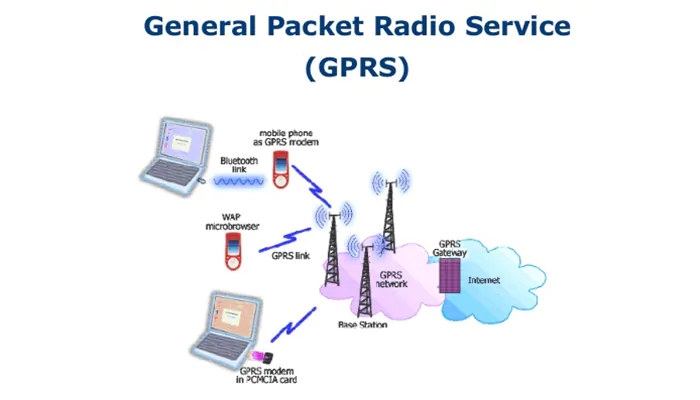

GPRS is often referred to as 2.5G network,having enabled a variety of telecomuication services before 3G,4G,adn 5G. This old techonolgy is gradually phased out in the current market.  At the time where GRS was first introduced to the market, it gained a lot of attention from companies and the major embedded features surprising the market includes  
  - faster data rates for downloads
  - multimedia messaging service
  - wireless application protocol  

and so on.  Many articles published in years between 2003 and 2005 suggested that the advent of the network had hit the market providing unprecedented levels of services for customers. Let's see how this techology has actually woroked in our case.

In [ ]:
gprs=[]
for i in data.columns:
    if search('gprs',i):
        gprs.append(i)

        result5=data.pivot_table('user_use_gprs',index=['user_type','churn'],aggfunc='count')
result5.index=result5.index.set_levels(['no','yes'],level=1)
result5=result5.reset_index()
result5=result5.rename(columns={'user_user_gprs':"number of user_gprs"})

In [ ]:
gprs=gprs[1:]
result6=data.pivot_table(gprs,index=['user_type','churn'],aggfunc='mean')
result6.index=result6.index.set_levels(['no','yes'],level=1)
result6=result6.reset_index()
result6=result6.rename(columns={
 "gprs_inactive_days":"gprs_inactive_days(avg)",
"gprs_session_count":"gprs_session_count(avg)",
"gprs_spendings":"gprs_spendings(avg)",
"gprs_usage":"gprs_usage(avg)",
"last_100_gprs_usage":"last_100_gprs_usage(avg)"})

In [ ]:
result5=result5.merge(result6,how='outer')
result5

In [ ]:
g=sns.catplot(x='user_type',y='gprs_inactive_days(avg)',col='churn',kind='bar',data=result5)
g.set_xticklabels(rotation=30)
g.set_xlabels('user_type',fontsize=14)
g.set_ylabels('gprs_inactive_days(avg)',fontsize=14)

In [ ]:
g=sns.catplot(x='user_type',y='gprs_spendings(avg)',col='churn',kind='bar',data=result5)
g.set_xticklabels(rotation=30)
g.set_xlabels('user_type',fontsize=14)
g.set_ylabels('gprs_spendings(avg)',fontsize=14)

In [ ]:
g=sns.catplot(x='user_type',y='gprs_usage(avg)',col='churn',kind='bar',data=result5)
g.set_xticklabels(rotation=30)
g.set_xlabels('user_type',fontsize=14)
g.set_ylabels('gprs_usage(avg)',fontsize=14)

In [ ]:
g=sns.catplot(x='user_type',y='last_100_gprs_usage(avg)',col='churn',kind='bar',data=result5)
g.set_xticklabels(rotation=30)
g.set_xlabels('user_type',fontsize=14)
g.set_ylabels('last_100_gprs_usage(avg)',fontsize=14)

There are two chatractersitcs we should pay attention to in evaluating how the newly introduced technology will affect the sales revenue. 

First,the introduction of new technology was not attractive to induce that whow are likely to be inactive.  The highest usage of the service like others was recorded by two groups(highly active consumers and return consumers). 

Also,  inactive days  are similar among all the user types.  What this means is that even repeated consumers who are loyal to the companies did not think the newly introduced technology was tempedto.Not only did the company fail to persuade the group with the higher possibility of ceasing thier service, but also it did not help their loyal customers to settle on the use of GPRS.

Finally, let's look at the correlation with user_lifetime.All the correlation with user_lifetime is below 0.2 and considered as weak realtionship. These are strong candidates for being dropped out. 

In [ ]:
result_corr=data.corr()['user_lifetime'].sort_values(ascending=False)
result_corr[gprs]

### 3. Constructing Model <a class='anchor' id=model></a>

In [ ]:
data1=data.copy()
data_response=data1.churn
data1=data1.drop(['churn','user_type'],axis=1)


### Logistic Regression <a class='anchor' id=logistic></a>

### 3.1.1 Feature Scaling <a class='anchor' id=scaling></a>

In [ ]:
conver_var=['user_intake','user_use_gprs','user_does_reload','user_does_reload'] 
def conversion(data):  
    for i in conver_var:
        data.loc[:,i]=data.loc[:,i].map(lambda x: 'no' if x==0 else 'yes')
    return data

data1=conversion(data1)



In [ ]:
def quant_qualt_columns(x):
    quant=[]
    qualt=[]
    for i in x.columns:
        if x.loc[:,i].dtype=='int64' or x.loc[:,i].dtype=='float64':
            quant.append(i)
        else:
            qualt.append(i)
    return {0:quant,1:qualt}

quant_columns=quant_qualt_columns(data1)[0]
qualt_columns=quant_qualt_columns(data1)[1]

In [ ]:
a=pd.DataFrame(scale(data1.loc[:,quant_columns]),columns=quant_columns)
b=data1.loc[:,qualt_columns]
data1=pd.concat([a,b],axis=1)

#since year is comprise of only zero, we will drop the feature 
data1=data1.drop('year',axis=1)

### 3.1.2 Create Dummy Variables<a class='anchor' id='dummy'></a>

In [ ]:
for var in qualt_columns:
    cat_list = pd.get_dummies(data1.loc[:,var],prefix=var)
    data1=data1.join(cat_list)
    


In [ ]:
data_final=pd.concat([data1,data_response],axis=1)
data_final=data_final.drop(conver_var,axis=1)

### 3.1.3 Imbalanced Data-SMOTE <a class='anchor' id=SMOTE></a>

More than often not, our training data are imbalanced, resulting in unintentional problems in machine learning classification where there is a disproportionate ratio of observations in each class. We bring some strategies to solve this imbalanced class issue. 

You may ask what is the big issue with unbalanced data. The biggest bottleneck we may face in the use of the data is our machine learning algorithm favors the one with greater counts. Without a proper procedure to deal with it, we can not expect to have a fair and accurate result.  

In this section, we will use the SMOTE( Synthetic Minority Oversampling Technique) to get our data balanced. I will not go further steps to explain the mechanism behind this algorithm but among two options I will choose to oversample our data. 


In [ ]:
X=data_final.loc[:,data_final.columns !='churn']
y=data_final.loc[:,'churn']

In [ ]:
os=SMOTE(random_state=0)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
columns=X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train,y_train)
os_data=pd.DataFrame(data=os_data_X,columns=columns)
os_data['churn']=os_data_y

#Check the numbers of our data
print("Length of oversampled data is                                            ",len(os_data_X))
print("Number of churn whose value is 0 in oversampled data                     ",len(os_data_y[os_data.churn==0]))
print("Number of chunr whose value is 1 in oversampled data in oversampled data ",len(os_data_y[os_data.churn==1]))

Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

### 3.1.4 3.1.4 Recursive Feature Elimination<a class='anchor' id=RFE></a> 

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 40)
rfe = rfe.fit(os_data_X, os_data_y.ravel())
print(rfe.support_)
print(rfe.ranking_)

###  3.1.5 Performance Test<a class='anchor' id='test'></a>

Estimation of beta coefficients is required to construct a model. Since the MLE of logistic regression does not have a closed-form solution, our attention tursn to optimization. We will test 7 methods by which we can check if our optimization is successfully terminated and record time it takes to complete the task. 


In [ ]:
col_index=np.where(rfe.support_)
col=os_data.columns[col_index]
X=os_data.loc[:,col]
y=os_data.churn

col

In [ ]:
tol = 0.0001
maxiter = 1000
DISP = 0


SOLVERS = ["newton", "nm","bfgs","lbfgs","powell","cg","ncg"] #,"basinhopping",]
for method in SOLVERS:
    t = time.time()
    model = Logit(y,X)
    result = model.fit(method=method, maxiter=maxiter,
                       niter=maxiter,
                       ftol=tol,
                       tol=tol, gtol=tol, pgtol=tol,  # Hmmm.. needs to be reviewed.
                       disp=DISP)
    print("sm.Logit", method, time.time() - t)
    print("--------------------------------------------------------- ")



It is the newton method that converges most fast but generate an error-cotaining result. We have no choice but to select lbfgs,the second fast model.

In [ ]:
model = Logit(y,X)
result = model.fit(method='lbfgs',maxiter=maxiter,
                       niter=maxiter,
                       ftol=tol,
                       tol=tol, gtol=tol, pgtol=tol, 
                       disp=DISP)

In [ ]:
result.summary()

In [ ]:
# second summary
drop_col=['calls_outgoing_spendings','calls_outgoing_to_abroad_spendings','sms_outgoing_to_onnet_count','user_intake_no',
          'user_intake_yes','user_does_reload_yes']

X=X.drop(drop_col,axis=1)
model=Logit(y,X)
result = model.fit(method='lbfgs',maxiter=maxiter,
                       niter=maxiter,
                       ftol=tol,
                       tol=tol, gtol=tol, pgtol=tol, 
                       disp=DISP)

In [ ]:
result.summary()

In [ ]:
# Third Summary
drop_col=['reloads_sum','calls_outgoing_spendings_max','last_100_calls_outgoing_to_onnet_duration','last_100_sms_outgoing_to_offnet_count']
X=X.drop(drop_col,axis=1)
model=Logit(y,X)
result = model.fit(method='lbfgs',maxiter=maxiter,
                       niter=maxiter,
                       ftol=tol,
                       tol=tol, gtol=tol, pgtol=tol, 
                       disp=DISP)

In [ ]:
result.summary()

In [ ]:
#Fourth Try
drop_col=['calls_outgoing_to_offnet_count','last_100_calls_outgoing_to_abroad_duration']
X=X.drop(drop_col,axis=1)
model=Logit(y,X)
result = model.fit(method='lbfgs',maxiter=maxiter,
                       niter=maxiter,
                       ftol=tol,
                       tol=tol, gtol=tol, pgtol=tol, 
                       disp=DISP)

In [ ]:
result.summary()

In [ ]:
#Fifth Try

drop_col=['calls_outgoing_to_abroad_duration']
X=X.drop(drop_col,axis=1)
model=Logit(y,X)
result = model.fit(method='lbfgs',maxiter=maxiter,
                       niter=maxiter,
                       ftol=tol,
                       tol=tol, gtol=tol, pgtol=tol, 
                       disp=DISP)

In [ ]:
#Sixth Try

drop_col=['calls_outgoing_to_onnet_spendings']
X=X.drop(drop_col,axis=1)
model=Logit(y,X)
result = model.fit(method='lbfgs',maxiter=maxiter,
                       niter=maxiter,
                       ftol=tol,
                       tol=tol, gtol=tol, pgtol=tol, 
                       disp=DISP)

In [55]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                73652
Model:                          Logit   Df Residuals:                    73626
Method:                           MLE   Df Model:                           25
Date:                Sun, 10 Nov 2019   Pseudo R-squ.:                  0.3381
Time:                        14:43:47   Log-Likelihood:                -33790.
converged:                       True   LL-Null:                       -51052.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
month                                          0.5292      0.016     33.004      0.000       0.498       0.561
user_lifetime                                  0.2646      0.013     20.284      0.000       0.239       0.290
min_outgoing_inactive_days                    -0.1280      0.016     -7.939      0.000      -0.160      -0.096
user_account_balance_last                     -0.4041      0.017    -23.538      0.000      -0.438      -0.370
reloads_inactive_days                          0.4150      0.011     37.840      0.000       0.394       0.436
calls_outgoing_count                          -0.2325      0.027     -8.530      0.000      -0.286      -0.179
calls_outgoing_duration                        0.4351      0.059      7.320      0.000       0.319       0.552
calls_outgoing_duration_max                   -0.3023      0.019    -16.124      0.000      -0.339      -0.266
calls_outgoing_inactive_days                   0.6814      0.021     31.909      0.000       0.640       0.723
calls_outgoing_to_offnet_spendings            -0.1803      0.032     -5.641      0.000      -0.243      -0.118
calls_outgoing_to_offnet_duration             -0.1590      0.059     -2.712      0.007      -0.274      -0.044
calls_outgoing_to_abroad_count                 0.0682      0.020      3.421      0.001       0.029       0.107
sms_outgoing_count                             0.2429      0.037      6.483      0.000       0.169       0.316
sms_outgoing_spendings                        -0.1440      0.028     -5.133      0.000      -0.199      -0.089
sms_outgoing_spendings_max                    -0.0774      0.013     -5.966      0.000      -0.103      -0.052
sms_outgoing_to_offnet_spendings              -0.1143      0.028     -4.088      0.000      -0.169      -0.060
sms_outgoing_to_abroad_count                  -0.0740      0.019     -3.954      0.000      -0.111      -0.037
sms_incoming_count                            -0.1584      0.019     -8.264      0.000      -0.196      -0.121
sms_incoming_from_abroad_count                -0.0652      0.016     -3.958      0.000      -0.097      -0.033
last_100_reloads_count                         0.0447      0.021      2.141      0.032       0.004       0.086
last_100_reloads_sum                           0.4180      0.029     14.520      0.000       0.362       0.474
last_100_calls_outgoing_duration              -0.6633      0.072     -9.154      0.000      -0.805      -0.521
last_100_calls_outgoing_to_offnet_duration     0.4210      0.064      6.608      0.000       0.296       0.546
last_100_sms_outgoing_count                   -0.1913      0.030     -6.478      0.000      -0.249      -0.133
last_100_sms_outgoing_to_onnet_count          -0.0649      0.015     -4.265      0.000      -0.095      -0.035
user_use_gprs_yes                             -0.8232      0.057    -14.479      0.000      -0.935      -0.712
======================

Logistic Regression Model Fitting

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
y_pred=logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix

confusion_matrix=confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[8977 2020]
 [2116 8983]]


The result is telling us we have 8977+8983 correct predictions and 2020+2116 incorrect predictions.